# Determination of beneficial tariff for telecom companies


The purpose of this project was to analyze customer behavior and find the optimal tariff based on the data of the customers of the mobile operator.



- A preliminary analysis of the use of tariffs for a sample of customers was carried out;
- The behavior of customers when using the operator's services was analyzed and the optimal sets of services for users were recommended;
- The hypotheses about the difference in the revenue of subscribers of different tariffs and the difference in the revenue of subscribers from Moscow and other regions were tested

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import bartlett
from scipy.stats import levene

In [2]:
data_calls = pd.read_csv('/Users/yuliyapletneva/calls.csv')
data_messages = pd.read_csv('/Users/yuliyapletneva/messages.csv')
data_internet = pd.read_csv('/Users/yuliyapletneva/internet.csv')
data_tariffs = pd.read_csv('/Users/yuliyapletneva/tariffs.csv')
data_users = pd.read_csv('/Users/yuliyapletneva/users.csv')

In [3]:
data_users.info()
data_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


##### Preparing data for analysis

In [4]:
data_calls.info()
data_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format = '%Y-%m-%d')
data_calls['month'] = data_calls['call_date'].dt.month
data_calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


Megaline (telecom company) always rounds up minutes and megabytes. If the user has spoken for only 1 second, a whole minute is counted in the tariff. Therefore, let's round up the call duration values.

In [6]:
data_calls['duration'] = np.ceil(data_calls['duration'])

Creating a pivot table for further merging

In [7]:
data_calls_pivot = data_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count'])
data_calls_pivot.head()

sum    count
              duration duration
user_id month                  
1000    5        159.0       22
        6        172.0       43
        7        340.0       47
        8        408.0       52
        9        466.0       58

In [8]:
data_calls_pivot.columns = ['calls_duration', 'calls_count']
data_calls_pivot.head()

calls_duration  calls_count
user_id month                             
1000    5               159.0           22
        6               172.0           43
        7               340.0           47
        8               408.0           52
        9               466.0           58

In [9]:
data_internet.head()
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [10]:
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format = '%Y-%m-%d')
data_internet['month'] = data_internet['session_date'].dt.month
data_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9


In [11]:
data_internet['mb_used'] = np.ceil(data_internet['mb_used'])

In [12]:
len(data_internet[data_internet['mb_used'] == 0])

19598

In [13]:
data_internet = data_internet[data_internet['mb_used'] != 0]

In [14]:
data_internet_pivot = data_internet.pivot_table(index=['user_id', 'month'],values='mb_used', aggfunc= 'sum')
data_internet_pivot.head()

mb_used
user_id month         
1000    5       2256.0
        6      23257.0
        7      14016.0
        8      14070.0
        9      14581.0

In [15]:
data_messages.info()
data_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [16]:
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format = '%Y-%m-%d')
data_messages['month'] = data_messages['message_date'].dt.month
data_messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [17]:
print(data_calls['duration'].mean())
print(data_calls['duration'].median())

7.158197890497367
6.0


<AxesSubplot:>

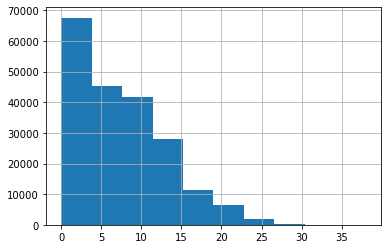

In [18]:
data_calls['duration'].hist()

In [19]:
len(data_calls[data_calls['duration'] == 0])

39613

In [20]:
data_calls = data_calls[data_calls['duration'] != 0]

In [21]:
print(data_calls['duration'].mean())
print(data_calls['duration'].median())

8.897879676552511
8.0


<AxesSubplot:>

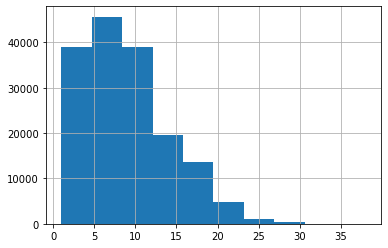

In [22]:
data_calls['duration'].hist()

The call database contains 39613 zero values. These could be missed calls. On the one hand, there are a lot of such values - almost 20%. But on the other hand, such calls are not charged, which means that they are not important for answering the research questions, so it is better to remove them from further analysis.
    
After removing the zero values on the histogram, the peak in the region of zero disappears, and the gap between the mean and the median also decreases.

In [23]:
data_messages_pivot = data_messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc= 'count')

In [24]:
data_messages_pivot.columns = ['messages']
data_messages_pivot.head()

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57

In [25]:
data_tariffs.info()
data_tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


##### Merging four datasets into one 

In [26]:
data = data_calls_pivot.merge(data_internet_pivot, on=('user_id', 'month'), how='outer').merge(data_messages_pivot, on=('user_id', 'month'), how='outer')
print(data.head()) 

               calls_duration  calls_count  mb_used  messages
user_id month                                                
1000    5               159.0         22.0   2256.0      22.0
        6               172.0         43.0  23257.0      60.0
        7               340.0         47.0  14016.0      75.0
        8               408.0         52.0  14070.0      81.0
        9               466.0         58.0  14581.0      57.0


In [27]:
tariff_name = data_users[['user_id', 'tariff']]

In [28]:
data = data.reset_index().merge(tariff_name, on='user_id', how='left')

In [29]:
data.head(10)

,user_id,month,calls_duration,calls_count,mb_used,messages,tariff
0,1000,5,159.0,22.0,2256.0,22.0,ultra
1,1000,6,172.0,43.0,23257.0,60.0,ultra
2,1000,7,340.0,47.0,14016.0,75.0,ultra
3,1000,8,408.0,52.0,14070.0,81.0,ultra
4,1000,9,466.0,58.0,14581.0,57.0,ultra
5,1000,10,350.0,57.0,14717.0,73.0,ultra
6,1000,11,338.0,43.0,14768.0,58.0,ultra
7,1000,12,333.0,46.0,9827.0,70.0,ultra
8,1001,11,430.0,59.0,18452.0,NaN,smart
9,1001,12,414.0,63.0,14053.0,NaN,smart


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3214 non-null   int64  
 1   month           3214 non-null   int64  
 2   calls_duration  3174 non-null   float64
 3   calls_count     3174 non-null   float64
 4   mb_used         3201 non-null   float64
 5   messages        2717 non-null   float64
 6   tariff          3214 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 200.9+ KB


In [31]:
for column in ['calls_duration', 'calls_count', 'mb_used', 'messages']:
    data[column] = data[column].fillna(0)
    data[column] = data[column].astype('int')

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         3214 non-null   int64 
 1   month           3214 non-null   int64 
 2   calls_duration  3214 non-null   int64 
 3   calls_count     3214 non-null   int64 
 4   mb_used         3214 non-null   int64 
 5   messages        3214 non-null   int64 
 6   tariff          3214 non-null   object
dtypes: int64(6), object(1)
memory usage: 200.9+ KB


In [33]:
data_tariffs.rename(columns={'tariff_name':'tariff'}, inplace=True)

In [34]:
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [35]:
data = data.merge(data_tariffs, on='tariff', how='left')

In [36]:
data.head(10)

,user_id,month,calls_duration,calls_count,mb_used,messages,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159,22,2256,22,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172,43,23257,60,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340,47,14016,75,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408,52,14070,81,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466,58,14581,57,ultra,1000,30720,3000,1950,150,1,1
5,1000,10,350,57,14717,73,ultra,1000,30720,3000,1950,150,1,1
6,1000,11,338,43,14768,58,ultra,1000,30720,3000,1950,150,1,1
7,1000,12,333,46,9827,70,ultra,1000,30720,3000,1950,150,1,1
8,1001,11,430,59,18452,0,smart,50,15360,500,550,200,3,3
9,1001,12,414,63,14053,0,smart,50,15360,500,550,200,3,3


**Calculating for each user:**

the number of calls made and spent minutes of conversation by months;

number of sent messages by month;

the volume of consumed Internet traffic by months;

In [37]:
for column in ['calls_duration', 'calls_count', 'mb_used', 'messages']:
    print(data.pivot_table(index='user_id', columns='month', values = column, aggfunc = 'sum'))

month      1      2      3      4      5      6      7      8      9       10  \
user_id                                                                         
1000      NaN    NaN    NaN    NaN  159.0  172.0  340.0  408.0  466.0   350.0   
1001      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
1002      NaN    NaN    NaN    NaN    NaN  117.0  214.0  289.0  206.0   212.0   
1003      NaN    NaN    NaN    NaN    NaN    NaN    NaN  380.0  961.0   855.0   
1004      NaN    NaN    NaN    NaN   35.0  171.0  135.0  137.0  117.0   145.0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
1495      NaN    NaN    NaN    NaN    NaN    NaN    NaN   92.0  813.0  1030.0   
1496     48.0  594.0  557.0  521.0  484.0  555.0  582.0  527.0  486.0   450.0   
1497      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   490.0   
1498      NaN    NaN    NaN    NaN    NaN    NaN  175.0  400.0  471.0   247.0   
1499      NaN    NaN    NaN 

**Calculating for each user:**

monthly revenue from each user (subtract the free limit from the total number of calls, messages and Internet traffic; multiply the remainder by the value from the tariff plan; add the subscription fee corresponding to the tariff plan)
   

In [38]:
def month_calc(row):
    calls = row['calls_duration']
    messages = row['messages']
    internet = row['mb_used']
    tariff_name = row['tariff']
   
    # limits on tariffs for calls, sms and internet
    minutes_lim = data.loc[data['tariff'] == tariff_name, 'minutes_included'].array[0]
    messages_lim = data.loc[data['tariff'] == tariff_name, 'messages_included'].array[0]
    internet_lim = data.loc[data['tariff'] == tariff_name, 'mb_per_month_included'].array[0]
   
    # overpayment on calls
    call_overlimit = max(calls - minutes_lim, 0)
    call_overpay = call_overlimit * data.loc[data['tariff'] == tariff_name, 'rub_per_minute'].array[0]
   
    # overpayment on messages
    message_overlimit = max(messages - messages_lim, 0)
    message_overpay = message_overlimit * data.loc[data['tariff'] == tariff_name, 'rub_per_message'].array[0]
   
    # overpayment on data
    internet_overlimit = np.ceil(max(internet - internet_lim, 0) / 1024)
    internet_overpay = internet_overlimit * data.loc[data['tariff'] == tariff_name, 'rub_per_gb'].array[0] 
   
    return (call_overpay + message_overpay + internet_overpay
            + data.loc[data['tariff'] == tariff_name, 'rub_monthly_fee'].array[0])
 


In [39]:
data['profit'] = data.apply(month_calc, axis=1)


Describing the behavior of the operator's customers based on the sample. 

How many minutes of conversation, how many messages and how much Internet traffic is required by users of each tariff per month? 

Calculating the mean, variance, and standard deviation. 

Plot histograms. 

Describing the distributions.

In [40]:
data_ultra = data.query('tariff == "ultra"')
data_smart = data.query('tariff == "smart"')

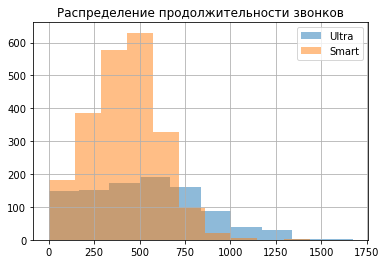

In [41]:
hist_1 = data_ultra['calls_duration'].hist(alpha=.5, grid=True, label='Ultra')
hist_2 = data_smart['calls_duration'].hist(alpha=.5, grid=True, label='Smart')
plt.title('Распределение продолжительности звонков')
hist_1.legend(loc = 'upper right')

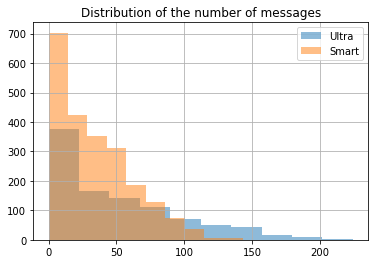

In [42]:
hist_1 = data_ultra['messages'].hist(alpha=.5, grid=True, label='Ultra')
hist_2 = data_smart['messages'].hist(alpha=.5, grid=True, label='Smart')
plt.title('Distribution of the number of messages')
hist_1.legend(loc = 'upper right')

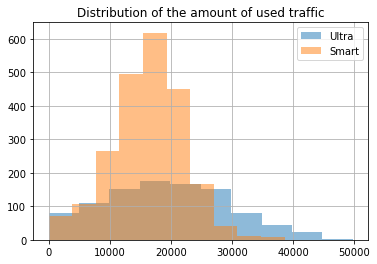

In [43]:
hist_1 = data_ultra['mb_used'].hist(alpha=.5, grid=True, label='Ultra')
hist_2 = data_smart['mb_used'].hist(alpha=.5, grid=True, label='Smart')
plt.title('Distribution of the amount of used traffic')
hist_1.legend(loc = 'upper right')

The values of all indicators on the smart tariff are distributed normally, on the ultra tariff the distribution is skewed to the left. At the same time, high values are much more common on the ultra tariff, which is logical, given that the tariff includes significantly more minutes, traffic and messages, and it is more often chosen by people who need it.

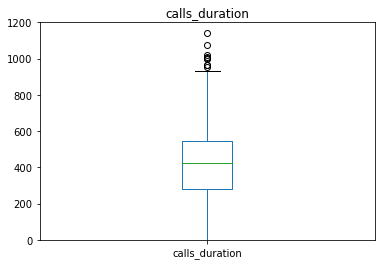

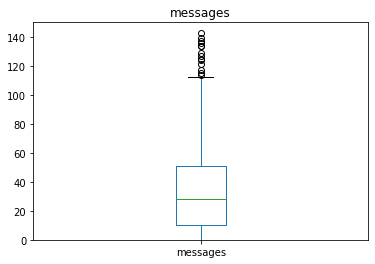

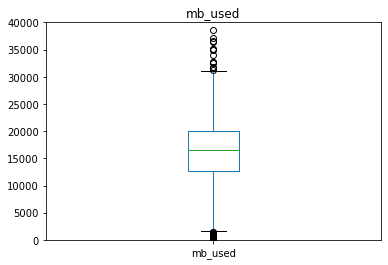

In [44]:
#boxplot for smart tariff
dict_for_auto = {
    
    'calls_duration' : [1200],
    'messages' : [150],
    'mb_used' : [40000],
}
 
for column in dict_for_auto:
 
    data_smart[column].plot(kind = 'box')
    plt.title(column)
    plt.ylim((0, dict_for_auto[column][0]))
    plt.show()

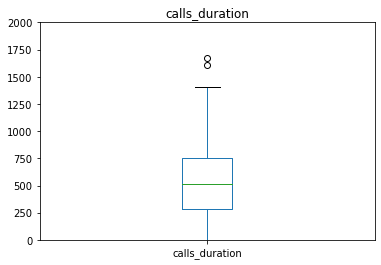

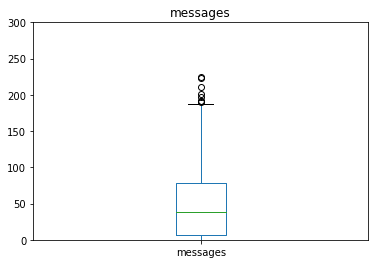

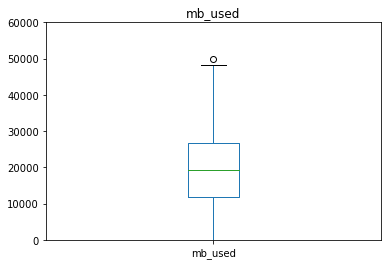

In [45]:
#boxplot for ultra tariff
dict_for_auto = {
    
    'calls_duration' : [2000],
    'messages' : [300],
    'mb_used' : [60000],
}
 
for column in dict_for_auto:
 
    data_ultra[column].plot(kind = 'box')
    plt.title(column)
    plt.ylim((0, dict_for_auto[column][0]))
    plt.show()

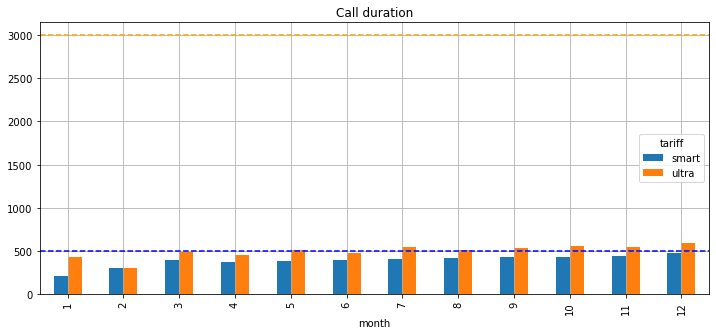

In [46]:
(data
    .pivot_table(index = 'month', columns = 'tariff', values = 'calls_duration', aggfunc = 'mean')
    .plot(kind = 'bar', grid=True, figsize=(12, 5))
)
plt.title('Call duration')
plt.axhline(3000, color = 'orange', linestyle = '--')
plt.axhline(500, color = 'blue', linestyle = '--')
plt.show()



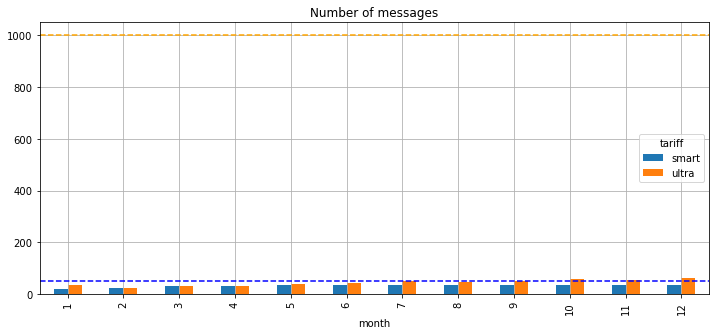

In [47]:
(data
    .pivot_table(index = 'month', columns = 'tariff', values = 'messages', aggfunc = 'mean')
    .plot(kind = 'bar', grid=True, figsize=(12, 5))
)
plt.title('Number of messages')
plt.axhline(1000, color = 'orange', linestyle = '--')
plt.axhline(50, color = 'blue', linestyle = '--')
plt.show()



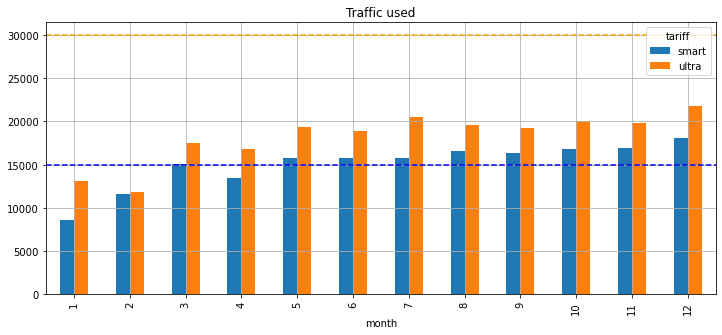

In [48]:
(data
    .pivot_table(index = 'month', columns = 'tariff', values = 'mb_used', aggfunc = 'mean')
    .plot(kind = 'bar', grid=True, figsize=(12, 5))
)
plt.title('Traffic used')
plt.axhline(30000, color = 'orange', linestyle = '--')
plt.axhline(15000, color = 'blue', linestyle = '--')
plt.show()



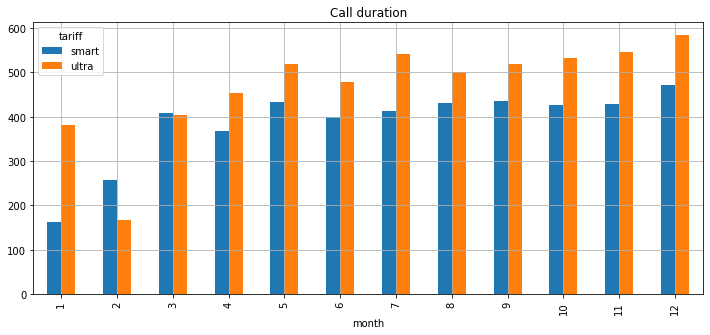

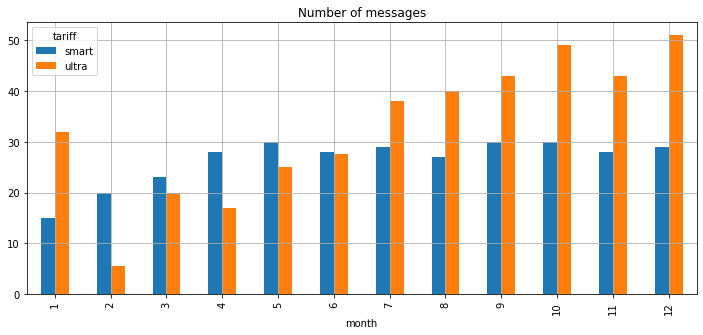

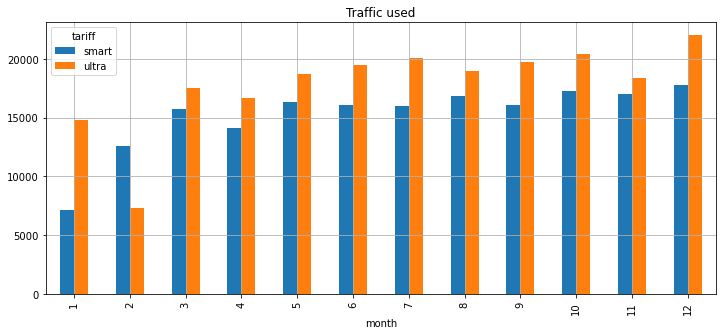

In [49]:
dict_for_auto = {
    
    'calls_duration' : ["Call duration"],
    'messages' : ["Number of messages"],
    'mb_used' : ["Traffic used"],
}

for column in dict_for_auto:
    (data
    .pivot_table(index = 'month', columns = 'tariff', values = column, aggfunc = 'median')
    .plot(kind = 'bar', grid=True, figsize=(12, 5))
    )
    plt.title(dict_for_auto[column][0])
    plt.show()

Calculating the average, variance and standard deviation for all indicators

In [50]:
print('Average call duration on ultra tariff:', data_ultra['calls_duration'].mean())
print('Variance of the duration of calls for the ultra tariff:', np.var(data_ultra['calls_duration'], ddof=1)) 
print('Standard deviation of call duration for ultra tariff:', np.std(data_ultra['calls_duration'], ddof=1))       

Average call duration on ultra tariff: 526.6233502538071
Variance of the duration of calls for the ultra tariff: 100873.63339730089
Standard deviation of call duration for ultra tariff: 317.60609785912624


In [51]:
print('Average call duration on smart tariff:', data_smart['calls_duration'].mean())
print('Variance of the duration of calls for the smart tariff:', np.var(data_smart['calls_duration'], ddof=1)) 
print('Standard deviation of call duration for smart tariff:', np.std(data_smart['calls_duration'], ddof=1))       

Average call duration on smart tariff: 417.9349484073576
Variance of the duration of calls for the smart tariff: 36219.31578434424
Standard deviation of call duration for smart tariff: 190.31372988921277


Both the histograms and the calculations show that users of the smart tariff behave more uniformly, while users of the ultra tariff change their behavior depending on the month. Perhaps this is due to the fact that the smart tariff is more often chosen for personal use, and the ultra tariff for work.

Despite the fact that users of the ultra tariff use more minutes and traffic, they, on average, are much farther from the tariff limits than users of the smart tariff, although they do not exceed the limit on average.

The difference appears when considering the amount of Internet traffic used. Smart users on average exceeded this limit from May to December, which means they paid extra.

##### Hypothesis testing:

the average revenue of users of the Ultra and Smart tariffs differs;

the average revenue of users from Moscow differs from the revenue of users from other regions;

In [52]:
print('Average revenue of smart tariff:', data_smart['profit'].mean())
print('Median smart tariff revenue:', data_smart['profit'].median())

Average revenue of smart tariff: 1294.6393001345896
Median smart tariff revenue: 1038.0


In [53]:
print('Average revenue of ultra tariff:', data_ultra['profit'].mean())
print('Median ultra tariff revenue:', data_ultra['profit'].median())

Average revenue of ultra tariff: 2071.0659898477156
Median ultra tariff revenue: 1950.0


In [54]:
print(bartlett(data_ultra['profit'], data_smart['profit']))

BartlettResult(statistic=635.6154935766345, pvalue=3.002696850995861e-140)


In [55]:
print(levene(data_ultra['profit'], data_smart['profit']))

LeveneResult(statistic=615.7061337306674, pvalue=1.6855369377883898e-124)


Tests have shown that the variances of the two samples are not the same, which means that the parameter equal_var = False must be set for the t test

Let's check if the revenue of the Ultra and Smart tariffs differs

**null hypothesis H₀**: average revenue values for tariffs are equal

**alternative hypothesis H₁**: average tariffs by revenue are not equal


In [56]:
alpha = 0.05

results = st.ttest_ind(data_ultra['profit'], data_smart['profit'], equal_var = False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-значение: 2.7240946993530856e-246
Rejecting the null hypothesis


 Let's check if the average revenue of users from Moscow differs from the revenue of users from other regions

In [57]:
city = data_users[['user_id', 'city']]

In [58]:
data = data.reset_index().merge(city, on='user_id', how='left')

In [59]:
def categoty(city):
    if city == "Москва":
        return 'Москва'
    return 'Другой город'


In [60]:
data['city_category'] = data['city'].apply(categoty)

In [61]:
print(levene(data.query('city_category == "Москва"')['profit'], data.query('city_category == "Другой город"')['profit']))

LeveneResult(statistic=6.758311885867127, pvalue=0.009373921759468934)


**null hypothesis H₀:** the average revenue of users from Moscow is equal to the revenue of users from other regions

**alternative hypothesis H₁:** the average revenue of users from Moscow is not equal to the revenue of users from other regions

In [62]:
alpha = 0.05

results = (st.ttest_ind(data.query('city_category == "Москва"')['profit'], data.query('city_category == "Другой город"')['profit'],
                      equal_var = False))
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-значение: 0.5126564657748214
Failed to reject the null hypothesis


### Conclusion

As the analysis shows, users of the smart tariff are more homogeneous and predictable in their behavior. Moreover, there is a significant statistical difference between the revenue received from the smart tariff and the revenue received from the ultra tariff. Ultra users, on average, are far from approaching the established limits, while their subscription fee is almost 4 times higher. The results showed that the ultra plan makes more money.

No difference was found between the revenue from the clients from Moscow and the clients from other cities.
